<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_BRAZPD_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG Evolution - BRAZPD Dataset
This notebook is based on the [Batch-DLG Evolution - Iris Dataset](https://github.com/mgozon/DLG-UROP/blob/main/Batch_DLG_Evolution_Iris_Dataset.ipynb), which implements the procedure in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) on the IRIS Dataset. In particular, a fully connected nueral network is trained using mini-batch gradients which are leaked. We now modify the code to run on the BRAZPD dataset.

# Setting up Libaries and Utilities

In [1]:
# setting up machine learning/visualization libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
#torch.manual_seed(100) # for generating the same random weights
from torch.utils.data import RandomSampler
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

# setting up optimal device
print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.13.1+cu116
Running on cpu


In [2]:
#@title Adding dlg_stats and dlg_models
from google.colab import drive
drive.mount('/content/drive/')
%run 'drive/MyDrive/UROP/Project Files/dlg_models.ipynb'
!cp 'drive/MyDrive/UROP/Project Files/BRAZPD_UnofM_all.csv' 'BRAZPD_UnofM_all.csv'
drive.flush_and_unmount()

Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
defined: assign_guess(guess, gt_dataset, n, verbose = False): guess_perm
defined: assign_best(guess, gt_dataset, n, verbose = False): best_match
defined: compute_stats(guess_perm, gt_data, recovered_threshold = 0.25): rel_errors, recovered_rate, cos_angles
defined: batch_DLG_Adam(net, criterion, device, original_dy_dx, batch_size, gt_data_len, gt_onehot_label_len, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.001, verbose = False): dummy_data, losses
defined: label_to_onehot(target, n_classes): onehot_target
defined: train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size = 32, epochs = 100): losses
defined: test_net(net, test_data, test_target): prints accuracy
defined: train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size = 32, epochs = 100, verbo

# Preprocess BRAZPD Dataset

In [3]:
# import BRAZPD dataset
import pandas as pd
import numpy as np
import os

filename = 'BRAZPD_UnofM_all.csv'
df = pd.read_csv(filename, engine='python', encoding = "ISO-8859-1")

In [4]:
# grab baseline features and target
baseline_set = ['CenterSizenpatients', 'Age', 'IncidentinPD', 'PrevalentinPDNet', \
                'Primaryrenaldisease', 'PreviousHD',\
                'Previoustx', 'DaviesScore', 'Peripheralarterydisease',\
                'Cancer', 'Stroke','Hypertension', 'HIV', 'HCV', 'HBC', 'Gender', 'Race',\
                'Familyincome', 'predialysiscare',\
                'timeofpredialysiscare', 'Educationdic4y', 'Region',\
                'Centerexperiencepatientyear', 'BMI', 'Distancefromcenter']
targets = ["death_event_1y"]
X_baseline = df[baseline_set].copy(); X_baseline.fillna(X_baseline.mean(), inplace=True); X_baseline = X_baseline.to_numpy()
Y_baseline = df[targets].copy(); Y_baseline.fillna(Y_baseline.mean(), inplace=True); Y_baseline = Y_baseline.to_numpy()

print(X_baseline)
print(Y_baseline)

[[128.        71.2        1.       ...  30.763889  20.7        1.      ]
 [128.        23.3        1.       ...  30.763889  28.3        1.      ]
 [128.        49.2        1.       ...  30.763889  31.5        1.      ]
 ...
 [ 66.        84.         1.       ...  16.416667  23.5        1.      ]
 [ 66.        54.2        1.       ...  16.416667  35.         1.      ]
 [ 66.        77.8        1.       ...  16.416667  20.6        3.      ]]
[[1]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [12]:
# rescale BRAZPD dataset
dst_length = X_baseline.shape[0]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_baseline)
print(scaled_data)

train_indices, test_indices = random_split(range(dst_length), [int(dst_length*4/5), dst_length - int(dst_length*4/5)])
train_indices = train_indices.indices
test_indices = test_indices.indices
train_data = scaled_data[train_indices]; train_target = Y_baseline[train_indices]
test_data = scaled_data[test_indices]; test_target = Y_baseline[test_indices]

input_dim = len(baseline_set)
output_dim = 2

[[-0.35269546  0.73954953  0.         ... -0.43880709 -0.86670574
  -0.70452708]
 [-0.35269546 -2.26347891  0.         ... -0.43880709  0.78158174
  -0.70452708]
 [-0.35269546 -0.63971197  0.         ... -0.43880709  1.47559752
  -0.70452708]
 ...
 [-0.91496972  1.54202894  0.         ... -1.01264725 -0.25944193
  -0.70452708]
 [-0.91496972 -0.32624345  0.         ... -1.01264725  2.23467729
  -0.70452708]
 [-0.91496972  1.15332797  0.         ... -1.01264725 -0.88839374
   1.0935143 ]]


# Setting up Fully Connected Neural Network

In [7]:
# ***not equivalent to nn.CrossEntropyLoss(), which combines both nn.LogSoftmax() and nn.NLLLoss()
def cross_entropy_for_onehot(pred, onehot_target):
   return torch.mean(torch.sum(- onehot_target * torch.log(pred), 1))

In [8]:
# a fully connected neural network with random weights and biases
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(input_dim, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, output_dim),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        out = self.body(x)
        return out

def weights_init(m):
    if hasattr(m, "weight"):
        nn.init.xavier_normal_(m.weight.data)
    if hasattr(m, "bias"):
        nn.init.normal_(m.bias.data)

# instantiation
net = FcNet().to(device)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Train Model Normally

score: 1045/1142


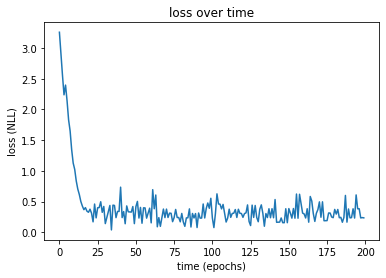

In [14]:
# note that parameters batch_size and epochs are tuned to yield a more accurate model
net.apply(weights_init)
batch_size = 32 # this affects the smoothness of the loss graph
epochs = 200
losses = train_net_Adam(net, criterion, device, train_data, train_target, output_dim, batch_size, epochs)
test_net(net, test_data, test_target)

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.show()

# Testing Single Batch DLG (not updated)

In [ ]:
# process specific batch gradient of flowers
def batch_grad(flower_indices):
    n = len(flower_indices)
    # flower_indices = torch.tensor(flower_indices)

    gt_data = torch.tensor(dst.data[flower_indices]).to(device)
    gt_label = torch.tensor(dst.target[flower_indices]).to(device); gt_label = torch.unsqueeze(gt_label, dim=1)
    gt_onehot_label = label_to_onehot(gt_label, n_classes=output_dim)

    out = net(gt_data.float())
    loss = criterion(out, gt_onehot_label)
    batch_dy_dx = torch.autograd.grad(loss, net.parameters())
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients
    
    return original_dy_dx, gt_data, gt_label

[109, 70, 6, 2, 28, 42, 122, 23, 8, 3, 137, 35, 38, 21, 139, 43]


  0%|          | 0/8000 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([7.2000, 3.6000, 6.1000, 2.5000], dtype=torch.float64) tensor([5.3359, 3.1551, 5.0663, 3.3782], grad_fn=<SelectBackward0>) RE (AE / TN):  0.22565735300434073
tensor([5.9000, 3.2000, 4.8000, 1.8000], dtype=torch.float64) tensor([4.5015, 2.9068, 4.7527, 2.3582], grad_fn=<SelectBackward0>) RE (AE / TN):  0.18172612614037514
tensor([4.6000, 3.4000, 1.4000, 0.3000], dtype=torch.float64) tensor([4.8542, 3.3936, 1.3398, 0.2990], grad_fn=<SelectBackward0>) RE (AE / TN):  0.04430953677438524
tensor([4.7000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([4.8730, 3.2727, 1.3083, 0.2530], grad_fn=<SelectBackward0>) RE (AE / TN):  0.033444315901999616
tensor([5.2000, 3.4000, 1.4000, 0.2000], dtype=torch.float64) tensor([4.8790, 3.2701, 1.3026, 0.2522], grad_fn=<SelectBackward0>) RE (AE / TN):  0.057046414037931224
tensor([4.4000, 3.2000, 1.3000, 0.2000], dtype=torch.float64) tensor([4.8733, 3.2771, 1.3085, 0.2539], grad_fn=<SelectBackwar

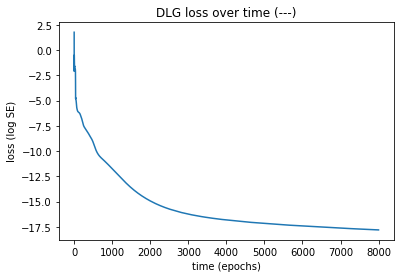

In [ ]:
# testing batch-DLG with Adam
net.apply(weights_init) # see how much easier it is to attack
batch_size = 16
flower_indices = list(RandomSampler(range(dst.data.shape[0]), num_samples=batch_size))
print(flower_indices)
batch_dy_dx, gt_data, gt_label = batch_grad(flower_indices)

dummy_data, losses = batch_DLG_Adam(net, criterion, device, batch_dy_dx, batch_size, gt_data_len = 4, gt_onehot_label_len = 3, epoch_mult = 500, w_decay = 1e-12, scheduler_k = 0.01, verbose = False)
guess_perm = assign_guess(dummy_data, gt_data, batch_size, verbose = True)       # assign all
assign_best(dummy_data, gt_data, batch_size, verbose = True)                     # closest match

plt.plot(torch.log(torch.tensor(losses)))
plt.title('DLG loss over time (---)')
plt.xlabel('time (epochs)')
plt.ylabel('loss (log SE)')
plt.savefig('dlg8-.png', dpi=300)

# DLG Evolution

In [17]:
# results of training a model + dlg
net.apply(weights_init)
epochs = 500
batch_size = 16
dlg_rate = 25
verbose = True
losses, dlg_timestamps, AA_REs, AA_RRate, AA_cos_angles, CA_REs, CA_RRate, CA_cos_angles \
    = train_net_Adam_DLG(net, criterion, device, scaler, train_data, train_target, output_dim, batch_size, epochs, verbose, dlg_rate, \
                         gt_data_len = input_dim, gt_onehot_label_len = output_dim, epoch_mult=200, w_decay=1e-12, scheduler_k = 0.01)
test_net(net, test_data, test_target)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 4.2000e+01,  4.5800e+01,  1.0000e+00,  1.0000e+00,  1.0000e+01,
         1.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  8.6736e-19,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  3.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  9.6458e+00,  2.5200e+01,  1.0000e+00],
       dtype=torch.float64) tensor([ 3.7210e+02,  1.7294e+01, -1.4558e+01, -2.7126e+01, -3.8012e+02,
        -3.7564e+00, -5.3458e-01, -8.6800e+00,  9.9300e+00, -6.1920e-01,
         1.8078e+00, -1.3154e+01, -4.9908e-01,  1.5279e+00, -1.5738e+00,
         1.3445e+01,  3.5657e+01,  1.8069e+00, -3.1119e+01,  3.6930e+01,
        -3.1906e+00, -4.0992e+01, -8.1647e+02,  6.0885e+00, -7.0797e+01]) RE (AE / TN):  14.258063319558286
tensor([1.4000e+02, 7.7700e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.4000e+01, 7.7100e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 3.0000e+00, 0.0000e+00, 2.0000e+00, 1.9472e+01, 2.4900e+01,
        3.0000e+00], dtype=torch.float64) tensor([-5.7701e+01,  4.7024e+01,  8.7978e-01,  2.2103e+00,  6.0482e+01,
         1.0707e+00, -1.9774e-03,  1.7869e+00,  1.0801e-02, -8.3080e-02,
        -5.0809e-02,  5.8577e-01,  2.5031e-02, -3.2875e-02, -1.7364e-02,
         1.2027e-01,  4.9043e-01,  5.5267e-01,  1.1715e+00,  2.9174e+01,
         4.3962e-02,  2.8426e+00,  4.6478e+00,  1.7606e+01, -3.3107e-01]) RE (AE / TN):  1.355393612083332
tensor([2.6800e+02, 6.5000e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00,

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 9.9000e+01,  4.7700e+01,  1.0000e+00,  1.0000e+00,  1.0000e+01,
         1.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  2.0000e+00,  1.0000e+00,  1.2400e+02,
         1.0000e+00,  3.0000e+00,  2.5033e+01,  3.2500e+01,  1.0000e+00],
       dtype=torch.float64) tensor([-2.9212e+03, -4.5827e+01, -5.4667e+00,  1.4407e+01,  2.3544e+02,
         1.4065e+01,  6.6901e-01, -2.1120e+01, -2.4187e+01,  5.4683e-01,
         1.1415e+00,  5.2159e+00, -3.5058e-01,  1.8682e+00, -1.3465e-01,
         2.2106e+01,  6.4255e+00, -2.6528e+01,  9.3329e+00, -4.7110e+02,
         1.3471e+01, -4.3017e+00,  1.7201e+02, -2.1043e+00, -1.3691e+01]) RE (AE / TN):  18.07741443892728
tensor([ 2.0900e+02,  4.3200e+01,  1.0000e+00,  1.0000e+00,  5.0000e+01,
         1.0000e+00,  1.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.00

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.8000e+01, 7.3600e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 2.0000e+00,
        1.0000e+00, 2.4000e+01, 0.0000e+00, 2.0000e+00, 1.6472e+01, 2.0000e+01,
        1.0000e+00], dtype=torch.float64) tensor([ 1.0646e+03, -3.1878e+02, -5.4158e+00, -3.8301e+01, -2.4864e+02,
         1.2434e+01,  3.9125e-01, -1.5407e+01, -6.1115e+00, -3.5278e+00,
        -1.2055e-02, -7.8513e+00, -8.2229e-01,  1.4804e+00, -1.6026e+00,
         1.2482e+01,  1.7565e+01,  3.0250e+01,  1.2775e+01, -1.9025e+01,
         1.7945e+01,  1.0093e+01, -2.7919e+01, -2.1200e+01, -9.0703e+00]) RE (AE / TN):  9.15736152787833
tensor([2.0000e+02, 5.5300e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.7000e+01,  5.2100e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  8.6736e-19,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  2.0000e+00,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  2.0000e+00,  8.8500e+00,  2.2100e+01,  4.0000e+00],
       dtype=torch.float64) tensor([ 4.5866e+02, -1.1911e+02, -2.1765e+01,  6.4746e+00, -5.1483e+02,
         1.3562e+01,  1.8552e+00, -1.3722e+01,  9.4203e-01,  4.7786e+00,
        -2.0410e-01,  2.8320e+00,  1.3109e+00,  9.8243e-01,  3.0648e-01,
         1.2543e+01,  5.6229e+00,  1.1153e+01,  7.6856e+00, -2.4242e+02,
         2.3683e+01, -3.0250e+00,  2.2885e+02,  9.8193e+01, -6.2354e+00]) RE (AE / TN):  12.142654743642689
tensor([1.0400e+02, 6.7700e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.1100e+02, 6.0300e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.9983e+01, 2.0300e+01,
        4.0000e+00], dtype=torch.float64) tensor([-3.7933e+02, -1.1569e+02, -5.4268e+00,  2.1170e+00, -2.6394e+02,
         6.5911e+00,  1.0564e+00, -9.0450e+00, -2.5062e+00,  1.9941e+00,
        -1.4647e+00,  9.2349e-01,  8.1011e-01,  3.5405e-01,  2.1256e-01,
         3.1172e+00,  4.8110e+00,  5.8985e+00,  3.0136e+00, -2.3778e+02,
         6.4267e+00, -4.6003e+00,  1.9681e+02,  3.9000e+01,  4.9560e-01]) RE (AE / TN):  4.464055535449738
tensor([5.1000e+01, 7.3600e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.6736e-19, 0.0000e+00,

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([2.6800e+02, 5.8800e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.2000e+01, 0.0000e+00, 2.0000e+00, 8.3083e+01, 2.6500e+01,
        1.0000e+00], dtype=torch.float64) tensor([-1.1256e+03, -1.3726e+02, -1.3264e+01,  8.9509e-01, -5.1887e+02,
         6.0455e+00,  2.4753e-01, -1.3678e+01, -1.8086e+00,  1.6336e+00,
        -9.8095e-01,  3.1559e+00,  5.4573e-01,  1.1139e-01,  7.9427e-02,
         4.8828e+00,  3.1268e+00,  3.5583e-01,  1.6091e+00, -3.6666e-01,
         1.5216e+01, -3.0085e+00,  2.9803e+02,  7.6945e+01,  7.5308e+00]) RE (AE / TN):  5.1647278166905295
tensor([1.5800e+02, 6.0200e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.6736e-19, 0.0000e+00

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 2.6700e+02,  4.5100e+01,  1.0000e+00,  1.0000e+00,  3.0000e+01,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.0000e+00,  2.0000e+00,  1.0000e+00,  6.0000e+01,
         1.0000e+00,  4.0000e+00,  8.1625e+01,  2.9700e+01,  4.0000e+00],
       dtype=torch.float64) tensor([-7.3568e+01, -2.2752e+02, -4.1112e+00, -4.1150e-01, -7.3945e+02,
         9.9248e+00,  9.8180e-01, -1.4103e+01, -3.3454e+00,  2.3378e+00,
        -8.7101e-01,  5.3298e+00,  8.4537e-01,  6.2677e-01, -4.8576e-02,
         5.0995e+00,  1.3496e+01,  2.0287e+00,  1.4738e+00, -2.7873e+01,
         1.6200e+01, -2.9351e+00,  3.0600e+02,  8.5217e+01, -1.7283e+00]) RE (AE / TN):  3.1439888736322015
tensor([3.9800e+02, 5.6800e+01, 1.0000e+00, 1.0000e+00, 5.0000e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.2800e+02, 6.7300e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 3.8000e+01, 0.0000e+00, 2.0000e+00, 3.0764e+01, 2.7100e+01,
        1.0000e+00], dtype=torch.float64) tensor([ 1.3375e+03,  7.2413e+01, -3.1972e+00,  7.0975e+00, -5.3742e+01,
         2.8187e+00, -2.1165e-01,  3.1060e+00,  4.4671e-01, -4.3746e-01,
         3.3804e-01,  6.4494e+00, -1.3502e-01,  2.1651e-02, -7.5872e-02,
         4.9332e-01,  1.4331e+00,  6.1476e-01,  1.5323e+00,  8.2402e+01,
         2.6389e-01,  3.1163e+00,  1.3059e+02,  4.2385e+01, -7.0049e-01]) RE (AE / TN):  6.982502959662774
tensor([ 4.2000e+01,  2.5300e+01,  1.0000e+00,  1.0000e+00,  1.0000e+01,
         1.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  1.0000e+00

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 6.5000e+01,  3.2200e+01,  1.0000e+00,  1.0000e+00,  1.0000e+02,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.0000e+00,  2.3167e+01,  1.9500e+01,  4.0000e+00],
       dtype=torch.float64) tensor([ 2.2310e+02,  1.0520e+02, -7.4501e+00,  2.3475e+01,  9.7232e+01,
         1.4017e+01,  6.9417e-04,  9.0735e-02,  1.5363e+00,  2.2521e+00,
         5.8892e-01, -1.6343e+01,  9.2261e-02, -1.7611e-01, -2.3712e-01,
        -3.8757e+00,  3.0177e+00, -9.2013e-01,  3.5981e+00, -2.1394e+02,
         1.1128e+00,  4.5355e+00, -2.3485e+02, -3.1852e+00, -6.8044e+00]) RE (AE / TN):  2.98502750584206
tensor([1.9500e+02, 6.0600e+01, 1.0000e+00, 1.0000e+00, 5.0000e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,


  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.5800e+02, 5.9800e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 8.9438e+01, 2.6500e+01,
        1.0000e+00], dtype=torch.float64) tensor([ 2.7380e+03, -2.6013e-01,  5.0540e+00,  4.8944e+00,  1.0191e+02,
        -8.1901e+00,  4.0816e-01,  4.9036e-01,  3.5764e-01, -1.2165e+00,
        -4.2012e-01, -4.6519e-02,  2.9374e-02,  3.7327e-01, -3.4769e-01,
         2.3070e+00,  1.7053e+01,  3.1337e+00, -1.1902e-02,  1.8800e+02,
         1.1716e+00, -2.4499e+00,  2.7560e+01,  4.6532e+01, -4.8478e-01]) RE (AE / TN):  6.231188301938184
tensor([2.2200e+02, 7.5500e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00,

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.9800e+02, 5.8400e+01, 1.0000e+00, 1.0000e+00, 1.3000e+01, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 4.0000e+01, 0.0000e+00, 5.0000e+00, 8.2958e+01, 3.0600e+01,
        2.0000e+00], dtype=torch.float64) tensor([ 1.8882e+03,  4.8092e+01, -4.5131e+00,  1.1558e+01, -3.9787e+01,
        -3.4679e+00,  3.3654e-01, -6.9108e-01, -4.4357e-01,  1.0011e+00,
        -3.6556e-01, -5.4131e+00, -6.4190e-03, -9.4502e-03, -8.3933e-02,
        -2.3294e+00,  1.6999e+01,  3.2631e+00, -4.5274e-01,  3.4059e+01,
         1.0361e+00,  1.3265e+00,  6.1153e+01,  1.4452e+01,  1.5204e+00]) RE (AE / TN):  3.602334211351119
tensor([ 1.7100e+02,  8.0000e+01,  1.0000e+00,  1.0000e+00,  1.0000e+02,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  8.6736e-19

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.9800e+02, 4.8700e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 1.0000e+00, 5.0000e+00, 8.2958e+01, 2.6800e+01,
        3.0000e+00], dtype=torch.float64) tensor([-2.5925e+03,  5.3783e+01, -1.0076e+01,  1.5374e+01,  3.5988e+01,
         1.3939e+01,  4.0718e-01, -7.9049e-01,  4.8703e-01,  8.8165e-01,
         3.0145e-01, -2.6499e+00,  8.1408e-02, -1.7533e-01, -1.3536e-01,
        -3.4865e+00, -2.1209e+01,  2.1224e+00, -4.4643e+00, -5.2892e+01,
         1.0706e+00, -6.7021e-01,  5.8947e+01,  1.0536e+01, -1.1250e-01]) RE (AE / TN):  7.151717831329699
tensor([6.0000e+01, 4.5300e+01, 1.0000e+00, 1.0000e+00, 1.3000e+01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        8.6736e-19, 0.0000e+00,

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([4.5000e+01, 7.0400e+01, 1.0000e+00, 1.0000e+00, 1.3000e+01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 1.3333e+01, 1.8700e+01,
        2.0000e+00], dtype=torch.float64) tensor([-6.6444e+01,  7.7583e+01,  8.0882e-01,  4.5337e+00,  9.6396e+01,
         1.6627e+00,  3.6832e-02,  1.7326e+00,  9.9612e-01, -1.0072e-01,
         5.6540e-01, -5.6402e-01, -7.5539e-02, -1.2715e-02, -4.5336e-02,
         4.7375e-01,  1.0219e+00,  4.1286e-01,  8.0798e-01, -1.6595e+01,
        -2.5330e-01,  3.3915e+00, -3.7832e+00,  1.7311e+01,  1.1696e+00]) RE (AE / TN):  1.6124825746992675
tensor([7.5000e+01, 6.9100e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([6.5000e+01, 4.7700e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00,
        1.0000e+00, 6.2000e+01, 0.0000e+00, 3.0000e+00, 2.3167e+01, 2.2000e+01,
        5.0000e+00], dtype=torch.float64) tensor([-4.2304e+02,  4.0447e-01, -8.2096e+00,  2.2323e+01, -1.1136e+02,
         6.7645e+00,  5.6276e-01, -8.8107e-01, -7.2263e-01,  7.8411e-01,
        -3.5461e-02, -5.5672e-01,  1.3759e-01,  1.9793e-01, -5.2426e-01,
         1.3527e+00, -1.9728e+01,  5.1985e+00, -2.0558e+00,  1.6508e+02,
         2.3500e+00, -1.1033e+00,  1.7164e+02,  3.6239e+01,  4.3658e-01]) RE (AE / TN):  5.01072831743283
tensor([4.8000e+01, 6.5600e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([ 3.5800e+02,  5.5800e+01,  1.0000e+00,  1.0000e+00,  1.0000e+02,
         1.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-19,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  4.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.9438e+01,  2.0300e+01,  2.0000e+00],
       dtype=torch.float64) tensor([-6.5882e+02,  9.6963e+01,  6.9207e+00,  1.0226e+01,  2.0699e+02,
         3.8586e+00, -6.0361e-01,  3.2709e+00,  1.6790e+00, -6.5215e-01,
         3.9689e-01, -1.3254e+00, -3.6245e-01, -3.5612e-01, -6.8473e-02,
        -2.5520e+00,  1.0442e+01, -1.5525e+00,  1.3907e+00, -1.0340e+02,
        -1.7364e+00,  7.2233e+00, -2.7912e+01,  1.6230e+01, -5.9245e+00]) RE (AE / TN):  2.675693633628901
tensor([5.8000e+01, 4.9400e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([5.1000e+01, 6.1900e+01, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 8.5667e+00, 2.6200e+01,
        2.0000e+00], dtype=torch.float64) tensor([ 1.0516e+02,  5.5209e+01,  9.6249e-01,  1.2286e+00,  3.0367e+01,
         7.1087e-01,  1.4114e-02,  9.9307e-01,  6.1894e-01, -4.5463e-02,
         2.2082e-02,  1.4254e+00, -1.9142e-02, -9.8414e-03, -1.1224e-02,
         1.3919e+00,  3.0275e+00,  1.5650e-01,  7.7588e-02, -1.6461e+01,
        -5.3817e-01,  4.5037e+00,  3.8617e+01,  2.5532e+01,  2.6097e+00]) RE (AE / TN):  0.838493904352441
tensor([2.6800e+02, 8.1900e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00,

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.2000e+02, 6.2900e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 8.1972e+01, 2.9700e+01,
        1.0000e+00], dtype=torch.float64) tensor([ 8.1492e+02, -3.6953e+00, -2.6302e+00,  1.2356e+01, -2.7536e+02,
        -3.2953e+00,  8.9999e-01, -4.3522e+00, -1.6647e+00,  1.4891e+00,
        -5.2669e-01,  1.5580e+00,  3.3319e-01,  2.9071e-01,  2.7719e-01,
         1.6914e+00,  8.0492e+00,  6.4208e+00,  6.3984e+00,  2.1346e+02,
         3.0413e+00, -5.0435e+00,  2.3525e+02,  4.2083e+01,  9.7509e+00]) RE (AE / TN):  1.9236193704712856
tensor([4.2000e+01, 3.8700e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([1.7100e+02, 2.6000e+01, 1.0000e+00, 1.0000e+00, 1.3000e+01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 3.0000e+00,
        1.0000e+00, 1.2000e+01, 1.0000e+00, 4.0000e+00, 4.2042e+01, 1.8000e+01,
        2.0000e+00], dtype=torch.float64) tensor([ 2.3700e+02,  5.5739e+01,  9.2557e-01,  1.2277e+00,  3.1280e+01,
        -2.1978e-01, -9.5174e-03,  1.2096e+00, -1.8887e-01, -5.6178e-03,
        -1.2477e-02,  2.4576e-01,  6.3851e-03, -2.7504e-03, -8.5233e-03,
         7.2280e-01,  1.8198e-01,  2.3145e-01, -6.6639e-01, -5.8851e+00,
        -1.1329e-01, -5.9302e-02,  6.2488e+01,  2.7054e+01,  3.9365e+00]) RE (AE / TN):  0.44598605204828085
tensor([ 3.9800e+02,  7.5500e+01,  1.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  8.6736e-

  0%|          | 0/3200 [00:00<?, ?it/s]

gt data vs guess perm (linear sum assignment): 
tensor([3.5800e+02, 5.7300e+01, 1.0000e+00, 1.0000e+00, 8.1000e+01, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 8.9438e+01, 3.5200e+01,
        1.0000e+00], dtype=torch.float64) tensor([ 8.4837e+02,  9.8629e+00,  1.0198e+01,  1.8267e+01, -1.8956e+02,
        -1.5154e+00,  1.2800e+00, -4.9371e+00,  3.9353e-01, -4.6953e-01,
        -8.2460e-01, -4.0709e+00,  4.1669e-01,  1.4689e-01,  1.0966e-01,
        -1.5052e-01,  6.4937e+00,  3.3163e+00,  1.0935e+01,  2.4314e+02,
         2.0121e+00, -2.1426e+00,  1.3039e+02,  4.4844e+01,  2.0493e-01]) RE (AE / TN):  1.6009187831872627
tensor([1.9300e+02, 7.8400e+01, 1.0000e+00, 1.0000e+00, 5.0000e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        8.6736e-19, 0.0000e+00

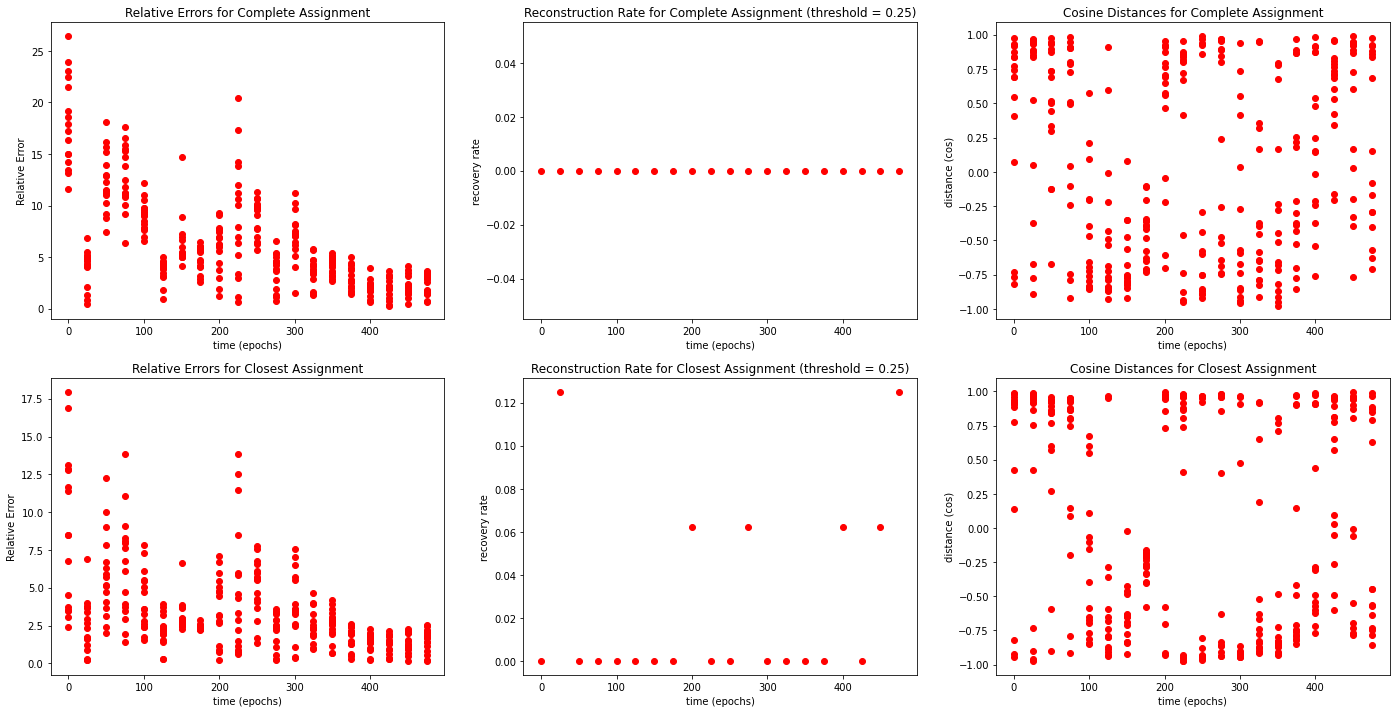

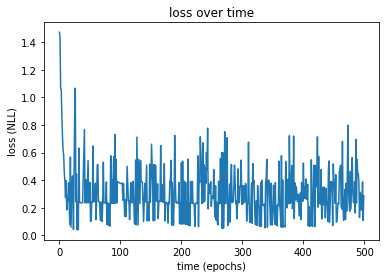

In [18]:
# create summary plots of MSE and normalized errors over time
fig, axs = plt.subplots(2, 3, figsize=(8*3, 6*2))

# complete assignment
axs[0, 0].plot(dlg_timestamps, AA_REs, 'ro')
axs[0, 0].set(title='Relative Errors for Complete Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[0, 1].plot(dlg_timestamps, AA_RRate, 'ro')
axs[0, 1].set(title='Reconstruction Rate for Complete Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[0, 2].plot(dlg_timestamps, AA_cos_angles, 'ro')
axs[0, 2].set(title='Cosine Distances for Complete Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

# closest assignment
axs[1, 0].plot(dlg_timestamps, CA_REs, 'ro')
axs[1, 0].set(title='Relative Errors for Closest Assignment', xlabel='time (epochs)', ylabel='Relative Error')

axs[1, 1].plot(dlg_timestamps, CA_RRate, 'ro')
axs[1, 1].set(title='Reconstruction Rate for Closest Assignment (threshold = 0.25)', xlabel='time (epochs)', ylabel='recovery rate')

axs[1, 2].plot(dlg_timestamps, CA_cos_angles, 'ro')
axs[1, 2].set(title='Cosine Distances for Closest Assignment', xlabel='time (epochs)', ylabel='distance (cos)')

plt.savefig('train_DLG_16_nm.png', dpi=300)
plt.show()

plt.plot(list(range(epochs)), losses)
plt.title('loss over time')
plt.xlabel('time (epochs)')
plt.ylabel('loss (NLL)')
plt.savefig('train_DLG_16_nm_loss.png', dpi=300)
plt.show()

In [ ]:
#@title Evolution Plots (not updated)
# evolution of SEs, normalized errors, cosine distances
fig, axs = plt.subplots(len(dlg_timestamps), 3, sharex='col', figsize=(24, len(dlg_timestamps)*4))

for i in range(len(dlg_timestamps)):
    axs[i, 0].hist(torch.log(torch.tensor(dlg_SEs[i])), 50)
    axs[i, 0].set(title=f'log SE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log SE', ylabel='frequency')

    axs[i, 1].hist(torch.log(torch.tensor(dlg_n_errors[i])), 50)
    axs[i, 1].set(title=f'log NE of batch DLG at epoch {dlg_timestamps[i]}', xlabel='log NE', ylabel='frequency')

    axs[i, 2].hist(dlg_cos_angles[i], 50)
    axs[i, 2].set(title=f'cosine distances of batch DLG at epoch {dlg_timestamps[i]}', xlabel='cosine distance', ylabel='frequency')

# Notes

In [ ]:
# Todo
# fix a set of data points and use that to measure improvements of DLG after changes in code
# try one hot encoding for categorical variables
# try running on only categorical variables and only numerical variables in the baseline features

# future tasks -----------------------------------------------------------
# also add comments to functions abstracted out into a package
# look at dp
# look at papers more related to FL
# estimate how quickly the model can be trained + attacked
# icml workshop for results
# consider other medical dataset
# possible idea - PCA with image tasks to capture similarity between reconstructed and true input data
# consider dropout with a probability like ~ 0.20-0.25 (or even, aggressively, 0.5 - good for generalization)